In [2]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
%matplotlib inline
training_file_path = os.path.expanduser('~/Documents/machine_learning_projects/predicting_backorders/Kaggle_Training_Dataset_v2.csv')
testing_file_path = os.path.expanduser('~/Documents/machine_learning_projects/predicting_backorders/Kaggle_Test_Dataset_v2.csv')
training_data = pd.read_csv(training_file_path)
testing_data = pd.read_csv(testing_file_path)
testing_data = testing_data.dropna()
training_data = training_data.dropna()
display(training_data.describe())

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06
mean,4.895098e+02,7.872267e+00,4.547493e+01,1.887439e+02,3.653390e+02,5.362801e+02,5.691140e+01,1.784835e+02,3.522319e+02,5.441272e+02,5.320380e+01,2.172666e+00,-1.014934e+00,-5.532225e-01,6.333207e-01
std,3.046168e+04,7.056024e+00,1.309357e+03,5.182992e+03,1.009962e+04,1.482576e+04,1.854775e+03,4.971129e+03,9.679297e+03,1.514871e+04,1.119034e+03,2.434021e+02,1.327273e+01,1.144580e+01,3.343933e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.900000e-01,6.900000e-01,0.000000e+00
50%,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.400000e-01,8.200000e-01,0.000000e+00
75%,7.800000e+01,9.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,2.500000e+01,5.000000e+00,1.600000e+01,3.300000e+01,5.000000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,2.057860e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


In [3]:
df = pd.DataFrame(np.random.choice(['yes', 'no'], size=(5,3)), columns=list('ABC'))
df = df.replace(['yes', 'no'], [1, 0])
display(df)
training_data = training_data.replace(['Yes','No'],[1,0])
display(training_data)
testing_data = testing_data.replace(['Yes','No'],[1,0])
#display(testing_data)

,A,B,C
0,0,0,0
1,1,0,0
2,1,0,1
3,1,0,1
4,0,0,0


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0,0,0,1,0,0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0,0,0,1,0,0
5,1044198,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.87,0.0,0,0,0,1,0,0
7,1045098,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,1,0,1,1,0,0
9,1045867,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.87,0.0,0,0,0,1,0,0
10,1045918,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.91,0.82,0.0,0,0,0,1,0,0
15,1049468,11.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.78,0.0,0,0,0,1,0,0
16,1050390,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.98,0.0,0,0,0,1,0,0
17,1050440,169.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.00,1.00,0.0,0,0,0,1,0,0
19,1050856,147.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,1.00,0.0,0,0,1,1,0,0


## Data Visualization & Feature Space Reduction



In [4]:
#general description of continuous variables
#display(training_data.describe())
display(training_data.median())
#How can the median of some of the categories be 0.00 exactly? Perhaps the medi

sku                  1955693.00
national_inv              14.00
lead_time                  8.00
in_transit_qty             0.00
forecast_3_month           0.00
forecast_6_month           0.00
forecast_9_month           0.00
sales_1_month              0.00
sales_3_month              1.00
sales_6_month              3.00
sales_9_month              4.00
min_bank                   0.00
potential_issue            0.00
pieces_past_due            0.00
perf_6_month_avg           0.84
perf_12_month_avg          0.82
local_bo_qty               0.00
deck_risk                  0.00
oe_constraint              0.00
ppap_risk                  0.00
stop_auto_buy              1.00
rev_stop                   0.00
went_on_backorder          0.00
dtype: float64

In [5]:
display(training_data.describe())

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,...,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06
mean,4.895098e+02,7.872267e+00,4.547493e+01,1.887439e+02,3.653390e+02,5.362801e+02,5.691140e+01,1.784835e+02,3.522319e+02,5.441272e+02,...,2.172666e+00,-1.014934e+00,-5.532225e-01,6.333207e-01,2.032538e-01,1.543825e-04,1.188090e-01,9.753675e-01,2.583545e-04,6.911927e-03
std,3.046168e+04,7.056024e+00,1.309357e+03,5.182992e+03,1.009962e+04,1.482576e+04,1.854775e+03,4.971129e+03,9.679297e+03,1.514871e+04,...,2.434021e+02,1.327273e+01,1.144580e+01,3.343933e+01,4.024199e-01,1.242412e-02,3.235638e-01,1.550025e-01,1.607134e-02,8.285021e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.900000e-01,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,...,0.000000e+00,8.400000e-01,8.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,7.800000e+01,9.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,2.500000e+01,5.000000e+00,1.600000e+01,3.300000e+01,5.000000e+01,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Notice that the mean and median of each category differs quite drastically. This indicates a need for data normalization. 

In [6]:
from sklearn import cross_validation as cv 
from sklearn import tree 
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [7]:
samples = training_data.sample(300000,random_state = 36)
#samples.dropna()
#can't log transform the whole dataset due to string/boolean values. You would have to apply log transform
#log_samples = np.log(samples)
#display(samples['national_inv'])
#careful with log transform if the value is zero. Log(0) gives you -inf.
#if you want them to stay zero after the transform then add 1 to all 0 values
#or turn all -inf to 0 
columns = samples.columns
#print(columns)
#if the column is either a float or an int, then log transform that data
"""continuous_features =[]
binary_features = []
for column in columns:
    type_value = type(samples[column].values[0])
    if (type_value == np.float64):
        continuous_features.append(column)
        samples_array = samples[column].values
        for i in range(len(samples_array)):
            if not(samples_array[i] > 0):
                samples_array[i] = 1
        log_data = np.log(samples[column])
        samples[column] = log_data
    else:
        binary_features.append(column)

display(samples.describe())
display(samples.median())
display(continuous_features)
binary_features.remove('sku')
binary_features.remove('went_on_backorder')
display(binary_features)"""


"continuous_features =[]\nbinary_features = []\nfor column in columns:\n    type_value = type(samples[column].values[0])\n    if (type_value == np.float64):\n        continuous_features.append(column)\n        samples_array = samples[column].values\n        for i in range(len(samples_array)):\n            if not(samples_array[i] > 0):\n                samples_array[i] = 1\n        log_data = np.log(samples[column])\n        samples[column] = log_data\n    else:\n        binary_features.append(column)\n\ndisplay(samples.describe())\ndisplay(samples.median())\ndisplay(continuous_features)\nbinary_features.remove('sku')\nbinary_features.remove('went_on_backorder')\ndisplay(binary_features)"

In [8]:
from sklearn.preprocessing import normalize
qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month',]
samples[qty_related] = normalize(samples[qty_related], axis=1)
display(samples)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1030677,1388552,0.712565,8.0,0.000000,0.000000,0.000000,0.000000,0.012724,0.068712,0.122154,...,0.000000,0.63,0.79,0.000000,0,0,1,1,0,0
555699,1903658,1.000000,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.78,0.78,0.000000,1,0,0,1,0,0
1349989,2935990,0.069861,2.0,0.025404,0.214348,0.385826,0.562067,0.090502,0.246897,0.373918,...,0.000000,0.98,0.98,0.000000,0,0,0,1,0,0
1370142,2956929,1.000000,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.99,0.99,0.000000,0,0,0,1,0,0
756475,2104421,0.157894,8.0,0.002657,0.195090,0.408020,0.543520,0.058831,0.173076,0.331350,...,0.000000,0.79,0.67,0.000000,0,0,0,1,0,0
959880,2307869,0.926703,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.123560,0.123560,...,0.000000,0.46,0.64,0.000000,1,0,0,1,0,0
899357,2247350,0.146529,8.0,0.000000,0.114413,0.343239,0.572065,0.048174,0.186674,0.367326,...,0.000000,0.52,0.63,0.000000,0,0,1,1,0,0
1425324,3014414,1.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.10,0.11,0.000000,0,0,0,1,0,0
617903,1965877,0.471405,8.0,0.000000,0.000000,0.000000,0.235702,0.000000,0.000000,0.471405,...,0.000000,0.99,0.98,0.000000,0,0,0,1,0,0
305751,1653726,1.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.71,0.75,0.000000,0,0,0,1,0,0


In [11]:
#Without any preprocessing, normalization, just using the out-of-the-box Random Forest Classifier
#strange thing is that as the number of trees grow, the model's F1 score gets lower and lower
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train_temp = samples.drop('went_on_backorder',axis = 1).values 
y_train_temp = samples['went_on_backorder'].values
X_test_temp = testing_data.drop('went_on_backorder', axis = 1).values
y_test_temp = testing_data['went_on_backorder'].values
clf_temp = RandomForestClassifier(n_estimators=100, max_depth = 15)
clf_temp = clf_temp.fit(X_train_temp, y_train_temp)
y_predict_temp = clf_temp.predict(X_test_temp)
score_temp = metrics.f1_score(y_test_temp, y_predict_temp)
y_predict_temp_proba = clf_temp.predict_proba(X_test_temp)
print score_temp


0.00153139356815


array([[224741,      6],
       [  2602,      2]])

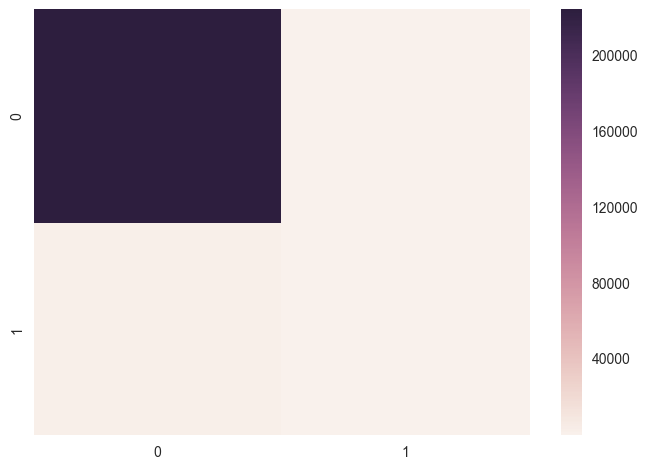

In [12]:
import matplotlib.pyplot as plt 
#taking a look at confusion matrix for the base Random Forest Classifier without class balancing
from sklearn.metrics import confusion_matrix 
import pandas as pd
import seaborn as sn
cm = confusion_matrix(y_test_temp, y_predict_temp)
display(cm)
sn.heatmap(cm)

array([  9.58785158e-06,   2.72318914e-03,   8.45649755e-06, ...,
         1.00043532e-02,   1.00043532e-02,   2.13450251e-01])

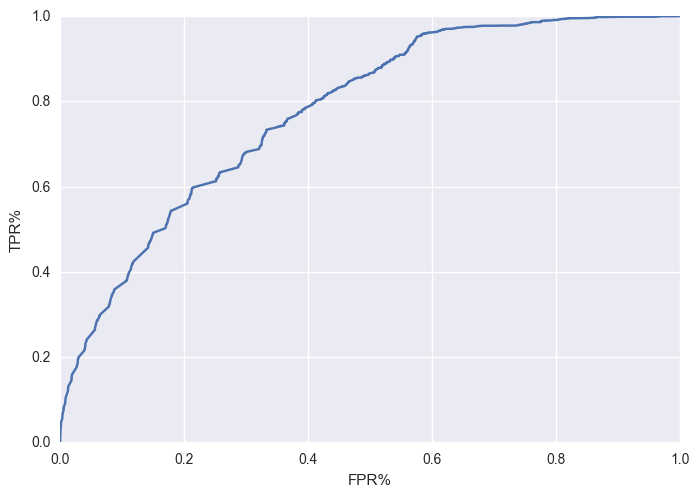

In [39]:
#time to do ROC curve analysis 
from sklearn.metrics import roc_curve, auc
#display(y_test_temp)
display(y_predict_temp_proba[:,1])
#display(y_predict_temp)
#display(y_predict_temp_proba.shape[0])
#display(y_predict_temp_proba[0])
#filtered_y_predict_temp_proba = []
#for i in range(0,y_predict_temp_proba.shape[0]):
    #row_max = max(y_predict_temp_proba[i])
    #filtered_y_predict_temp_proba.append(row_max)
#display(filtered_y_predict_temp_proba)
fpr, tpr, thresholds = roc_curve(y_test_temp, y_predict_temp_proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.show()

In [58]:
display(samples)
display(samples.isnull().any())

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1030677,1388552,280.0,8.0,0.0,0.0,0.0,0.0,5.0,27.0,48.0,...,0.0,0.63,0.79,0.0,0,0,1,1,0,0
555699,1903658,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.78,0.0,1,0,0,1,0,0
1349989,2935990,88.0,2.0,32.0,270.0,486.0,708.0,114.0,311.0,471.0,...,0.0,0.98,0.98,0.0,0,0,0,1,0,0
1370142,2956929,109.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0,0,0,1,0,0
756475,2104421,416.0,8.0,7.0,514.0,1075.0,1432.0,155.0,456.0,873.0,...,0.0,0.79,0.67,0.0,0,0,0,1,0,0
959880,2307869,15.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.46,0.64,0.0,1,0,0,1,0,0
899357,2247350,73.0,8.0,0.0,57.0,171.0,285.0,24.0,93.0,183.0,...,0.0,0.52,0.63,0.0,0,0,1,1,0,0
1425324,3014414,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.11,0.0,0,0,0,1,0,0
617903,1965877,2.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.99,0.98,0.0,0,0,0,1,0,0
305751,1653726,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.71,0.75,0.0,0,0,0,1,0,0


sku                  False
national_inv         False
lead_time            False
in_transit_qty       False
forecast_3_month     False
forecast_6_month     False
forecast_9_month     False
sales_1_month        False
sales_3_month        False
sales_6_month        False
sales_9_month        False
min_bank             False
potential_issue      False
pieces_past_due      False
perf_6_month_avg     False
perf_12_month_avg    False
local_bo_qty         False
deck_risk            False
oe_constraint        False
ppap_risk            False
stop_auto_buy        False
rev_stop             False
went_on_backorder    False
dtype: bool

In [10]:
from sklearn import cross_validation as cv 
from sklearn import tree 
from sklearn.metrics import r2_score
#define the feature column 
#pd.scatter_matrix(samples, alpha = 0.3, figsize = (14,30), diagonal = 'kde');
#clearly from the graph, you need to either break it up into different parts or you can try a different viualization 
#try using PCA to perhaps remove some unnecessary features 

#'national_inv','lead_time', 'in_transit_qty', 'forecast_3_month','forecast_6_month', 'forecast_9_month','sales_1_month'
#lead time seems to be pretty uncorrelated 
#national_inv seems to be uncorrelated sales_1_month, sales_3_month, sales_6_month, sales_9_month, min_bank, perf_6_month_average and perf_12_month average
#perf_6_month_average and perf_12_month_average seems to be uncorrelated with most things 
#but perf_6_month_average and perf_12_month_average seem to be correlated with eachother however 
#local_bo_quantity seems to be pretty uncorrelated with everything 
#Every other combination has semblance of correlation 



In [11]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
from sklearn import cross_validation as cv 
from sklearn import tree 
from sklearn.metrics import r2_score
#file_log_transformed_data = 'log_transformed_training_data.csv'
log_transformed_data_file_path = os.path.expanduser('~/Documents/machine_learning_projects/predicting_backorders/log_transformed_training_data.csv')
samples.to_csv(log_transformed_data_file_path, sep=',', encoding='utf-8')
test_size = 0.25

for i in range(0,len(continuous_features)):
    continuous_features_copy = continuous_features[:]
    target_col = continuous_features[i]
    new_data = pd.read_csv(log_transformed_data_file_path)
    new_data.drop(target_col, axis = 1, inplace = True)
    continuous_features_copy.remove(target_col)
    X_all = new_data[continuous_features_copy]
    y_all = samples[target_col]
    regressor = tree.DecisionTreeRegressor(random_state = 1)
    X_train, X_test, y_train, y_test = cv.train_test_split(X_all, y_all, test_size=test_size, random_state=0)
    # TODO: Create a decision tree regressor and fit it to the training set
    regressor.fit(X_train,y_train)
    y_predict = regressor.predict(X_test)
    # TODO: Report the score of the prediction using the testing set
    score = r2_score(y_test, y_predict)
    print 'The current R^2 score for '
    print target_col
    print ' is '
    print score

The current R^2 score for 
national_inv
 is 
0.519534372801
The current R^2 score for 
lead_time
 is 
-0.242336728601
The current R^2 score for 
in_transit_qty
 is 
0.420370820836
The current R^2 score for 
forecast_3_month
 is 
0.853610542765
The current R^2 score for 
forecast_6_month
 is 
0.952504998531
The current R^2 score for 
forecast_9_month
 is 
0.936135393642
The current R^2 score for 
sales_1_month
 is 
0.911882967156
The current R^2 score for 
sales_3_month
 is 
0.967769848242
The current R^2 score for 
sales_6_month
 is 
0.982883038943
The current R^2 score for 
sales_9_month
 is 
0.974973086539
The current R^2 score for 
min_bank
 is 
0.756672054706
The current R^2 score for 
pieces_past_due
 is 
-0.93621722827
The current R^2 score for 
perf_6_month_avg
 is 
0.678567004037
The current R^2 score for 
perf_12_month_avg
 is 
0.575707057242
The current R^2 score for 
local_bo_qty
 is 
-0.209427709621


In [12]:
#once you figure out how many features are unnecessary due to high correlation 
#with other variables. The unnecessary features seem to be:
#forecast_6_month, forecast_9_month, sales_1_month, sales_3_month, sales_6_month, sales_9_month
#clearly some of these are redundant if not all, perhaps we will retain forecast 3_month and 
#sales_1_month since they have the least amount of correlation with their respective categories
#now we need to try to do correlation testing with all the binary values
from sklearn import tree
from sklearn import metrics

for i in range(0,len(binary_features)):
    binary_features_copy = binary_features[:]
    target_col = binary_features[i]
    new_data = pd.read_csv(log_transformed_data_file_path)
    new_data.drop(target_col, axis = 1, inplace = True)
    binary_features_copy.remove(target_col)
    X_all = new_data[binary_features_copy]
    y_all = samples[target_col]
    clf = tree.DecisionTreeClassifier()
    X_train, X_test, y_train, y_test = cv.train_test_split(X_all, y_all, test_size=test_size, random_state=42)
    #display(binary_features)
    #display(X_all)
    #display(y_all)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    score = metrics.f1_score(y_test, y_predict)
    print 'The current F1 score for '
    print target_col
    print ' is '
    print score

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The current F1 score for 
potential_issue
 is 
0.0
The current F1 score for 
deck_risk
 is 
0.129773691655
The current F1 score for 
oe_constraint
 is 
0.0
The current F1 score for 
ppap_risk
 is 
0.004662004662
The current F1 score for 
stop_auto_buy
 is 
0.987891305228
The current F1 score for 
rev_stop
 is 
0.0


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


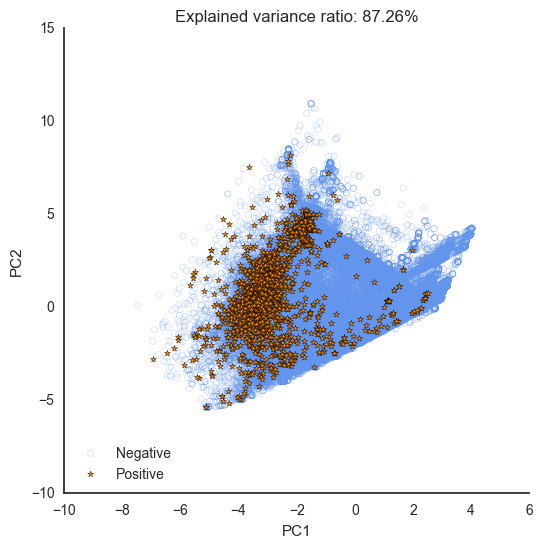

In [84]:
#code is courtesy of Rodrigo Santos from Kaggle 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
#Seems like the only the only highly correlated binary feature is stop_auto_buy
#next thing to do now is PCA 
def plot_2d(X, y, title=''):
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(X)

    from sklearn.decomposition import PCA
    dec = PCA(n_components=13)
    X_reduced = dec.fit_transform(X_std)
    
    f, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_reduced[y==0,0], X_reduced[y==0,1], alpha=0.5, 
               facecolors='none', edgecolors='cornflowerblue', label="Negative")
    ax.scatter(X_reduced[y==1,0], X_reduced[y==1,1], c='darkorange', marker='*', 
               label='Positive')
    plt.title("Explained variance ratio: %.2f%%" % (100*dec.explained_variance_ratio_.sum()))
    ax.legend(loc='lower left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.show()
    
X_train_sample = samples.drop('went_on_backorder',axis=1).values
y_train_sample = samples['went_on_backorder'].values

plot_2d(X_train_sample, y_train_sample)

In [82]:
#let's construct a random forest classifier without any calibration. 
#ensure that you are using the principal components you constructed as the features
#we will have to redo the code for PCA on the features 
from sklearn.preprocessing import StandardScaler
X_train_std = StandardScaler().fit_transform(X_train_sample)

from sklearn.decomposition import PCA
PCA_train = PCA(n_components=15)
X_train_reduced = PCA_train.fit_transform(X_train_std)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train_reduced, y_train_sample)

#print(100*dec.explained_variance_ratio_.sum())

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [83]:
X_dataset_test = testing_data.drop('went_on_backorder', axis=1).values
y_dataset_test = testing_data['went_on_backorder'].values
X_dataset_test_std = StandardScaler().fit_transform(X_dataset_test)
PCA_test = PCA(n_components = 15)
X_dataset_test_reduced = PCA_test.fit_transform(X_dataset_test_std)
y_dataset_test_predictions = clf.predict(X_dataset_test_reduced)
test_score = metrics.f1_score(y_dataset_test, y_dataset_test_predictions)
print test_score 

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.000759589821496
